<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np, pandas as pd, seaborn as sns  
import os, warnings, time
from datetime import datetime as dt
from matplotlib import pyplot as plt

%matplotlib inline

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)
warnings.filterwarnings(action="ignore")
seed = 123456789

# Outils projet

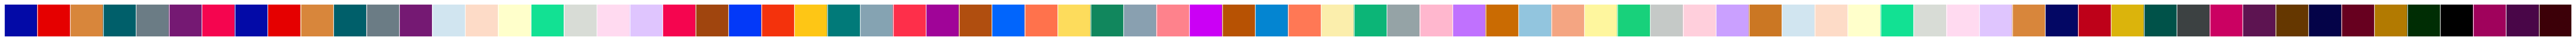

In [2]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973",
            "#f5054f", 
            "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", "#d1e5f0", "#fddbc7",
            "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#f5054f", "#a0450e",
            "#0339f8", "#f4320c", "#fec615", "#017a79", "#85a3b2", "#fe2f4a", "#a00498", "#b04e0f",
            "#0165fc", "#ff724c", "#fddc5c", "#11875d", "#89a0b0", "#fe828c", "#cb00f5", "#b75203",
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#ffb7ce", "#c071fe", "#ca6b02",
            "#92c5de", "#f4a582", "#fef69e", "#18d17b", "#c5c9c7", "#ffcfdc", "#caa0ff", "#cb7723",
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#d8863b",
            "#030764", "#be0119", "#dbb40c", "#005249", "#3c4142", "#cb0162", "#5d1451", "#653700",
            "#040348", "#67001f", "#b27a01", "#002d04", "#000000", "#a0025c", "#490648", "#3c0008"
          ]

paletteA = ['#b2182b','#008827','#053061','#ffa500', '#34495e', '#e74c3c', 
          '#9b59b6', '#0165fc','#2ecc71', '#cb7723', '#89a0b0']

sns.palplot(sns.color_palette(palette))

In [3]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import NuSVC, SVC, OneClassSVM
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel

from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from lightgbm import LGBMClassifier
from xgboost  import XGBClassifier
from sklearn.metrics import roc_curve, auc

from sklearn.metrics  import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                             precision_score, recall_score, f1_score, jaccard_score,  \
                             precision_recall_curve, average_precision_score

In [4]:
repertoireRacine  = '.'
nomProjet         = 'La classification des Champignons'

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

In [5]:
donnees = pd.read_csv('../donnees/mushrooms.csv')
donnees.columns = [str(x).replace('-','_')
                       for x in list(donnees.columns)]

donnees.drop(columns='veil_type', inplace=True)
donnees.rename(columns={'class': 'Cible'}, inplace=True)
donnees.head()

,Cible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g


In [6]:
donnees.cap_shape.sort_values().unique()

array(['b', 'c', 'f', 'k', 's', 'x'], dtype=object)

In [7]:
{n:i for i,n in enumerate(list(donnees.cap_shape.sort_values().unique()))}

{'b': 0, 'c': 1, 'f': 2, 'k': 3, 's': 4, 'x': 5}

In [8]:
dictCS = {n:i for i,n in enumerate(list(donnees.cap_shape.sort_values().unique()))}
donnees.cap_shape.apply(lambda x: dictCS[x])

0       5
1       5
2       0
3       5
4       5
       ..
8119    3
8120    5
8121    2
8122    3
8123    5
Name: cap_shape, Length: 8124, dtype: int64

In [9]:
donnees.head()

,Cible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g


In [10]:
colonnes = donnees.drop(columns=['Cible']).columns
colonnes

Index(['cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor',
       'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color',
       'stalk_shape', 'stalk_root', 'stalk_surface_above_ring',
       'stalk_surface_below_ring', 'stalk_color_above_ring',
       'stalk_color_below_ring', 'veil_color', 'ring_number', 'ring_type',
       'spore_print_color', 'population', 'habitat'],
      dtype='object')

In [11]:
from sklearn.preprocessing import LabelEncoder
import copy as cp
modelsLEd = {} 

for col in donnees.columns:
    labelencoder=LabelEncoder()
    labelencoder.fit(donnees[col])
    modelsLEd[col] = cp.deepcopy(labelencoder)

In [12]:
import pickle
pickle_file = "champignonsLE.pickle"

with open(pickle_file, 'wb') as f:
    pickle.dump( modelsLEd,f)

In [13]:
pickle_file = "champignonsLE.pickle"

with open(pickle_file, 'rb') as f:
    modelsLEd = pickle.load(f)

In [14]:
donnees.head()    

,Cible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g


In [15]:
for col in donnees.columns:
    donnees[col] = modelsLEd[col].transform(donnees[col])
    
donnees.head()    

,Cible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


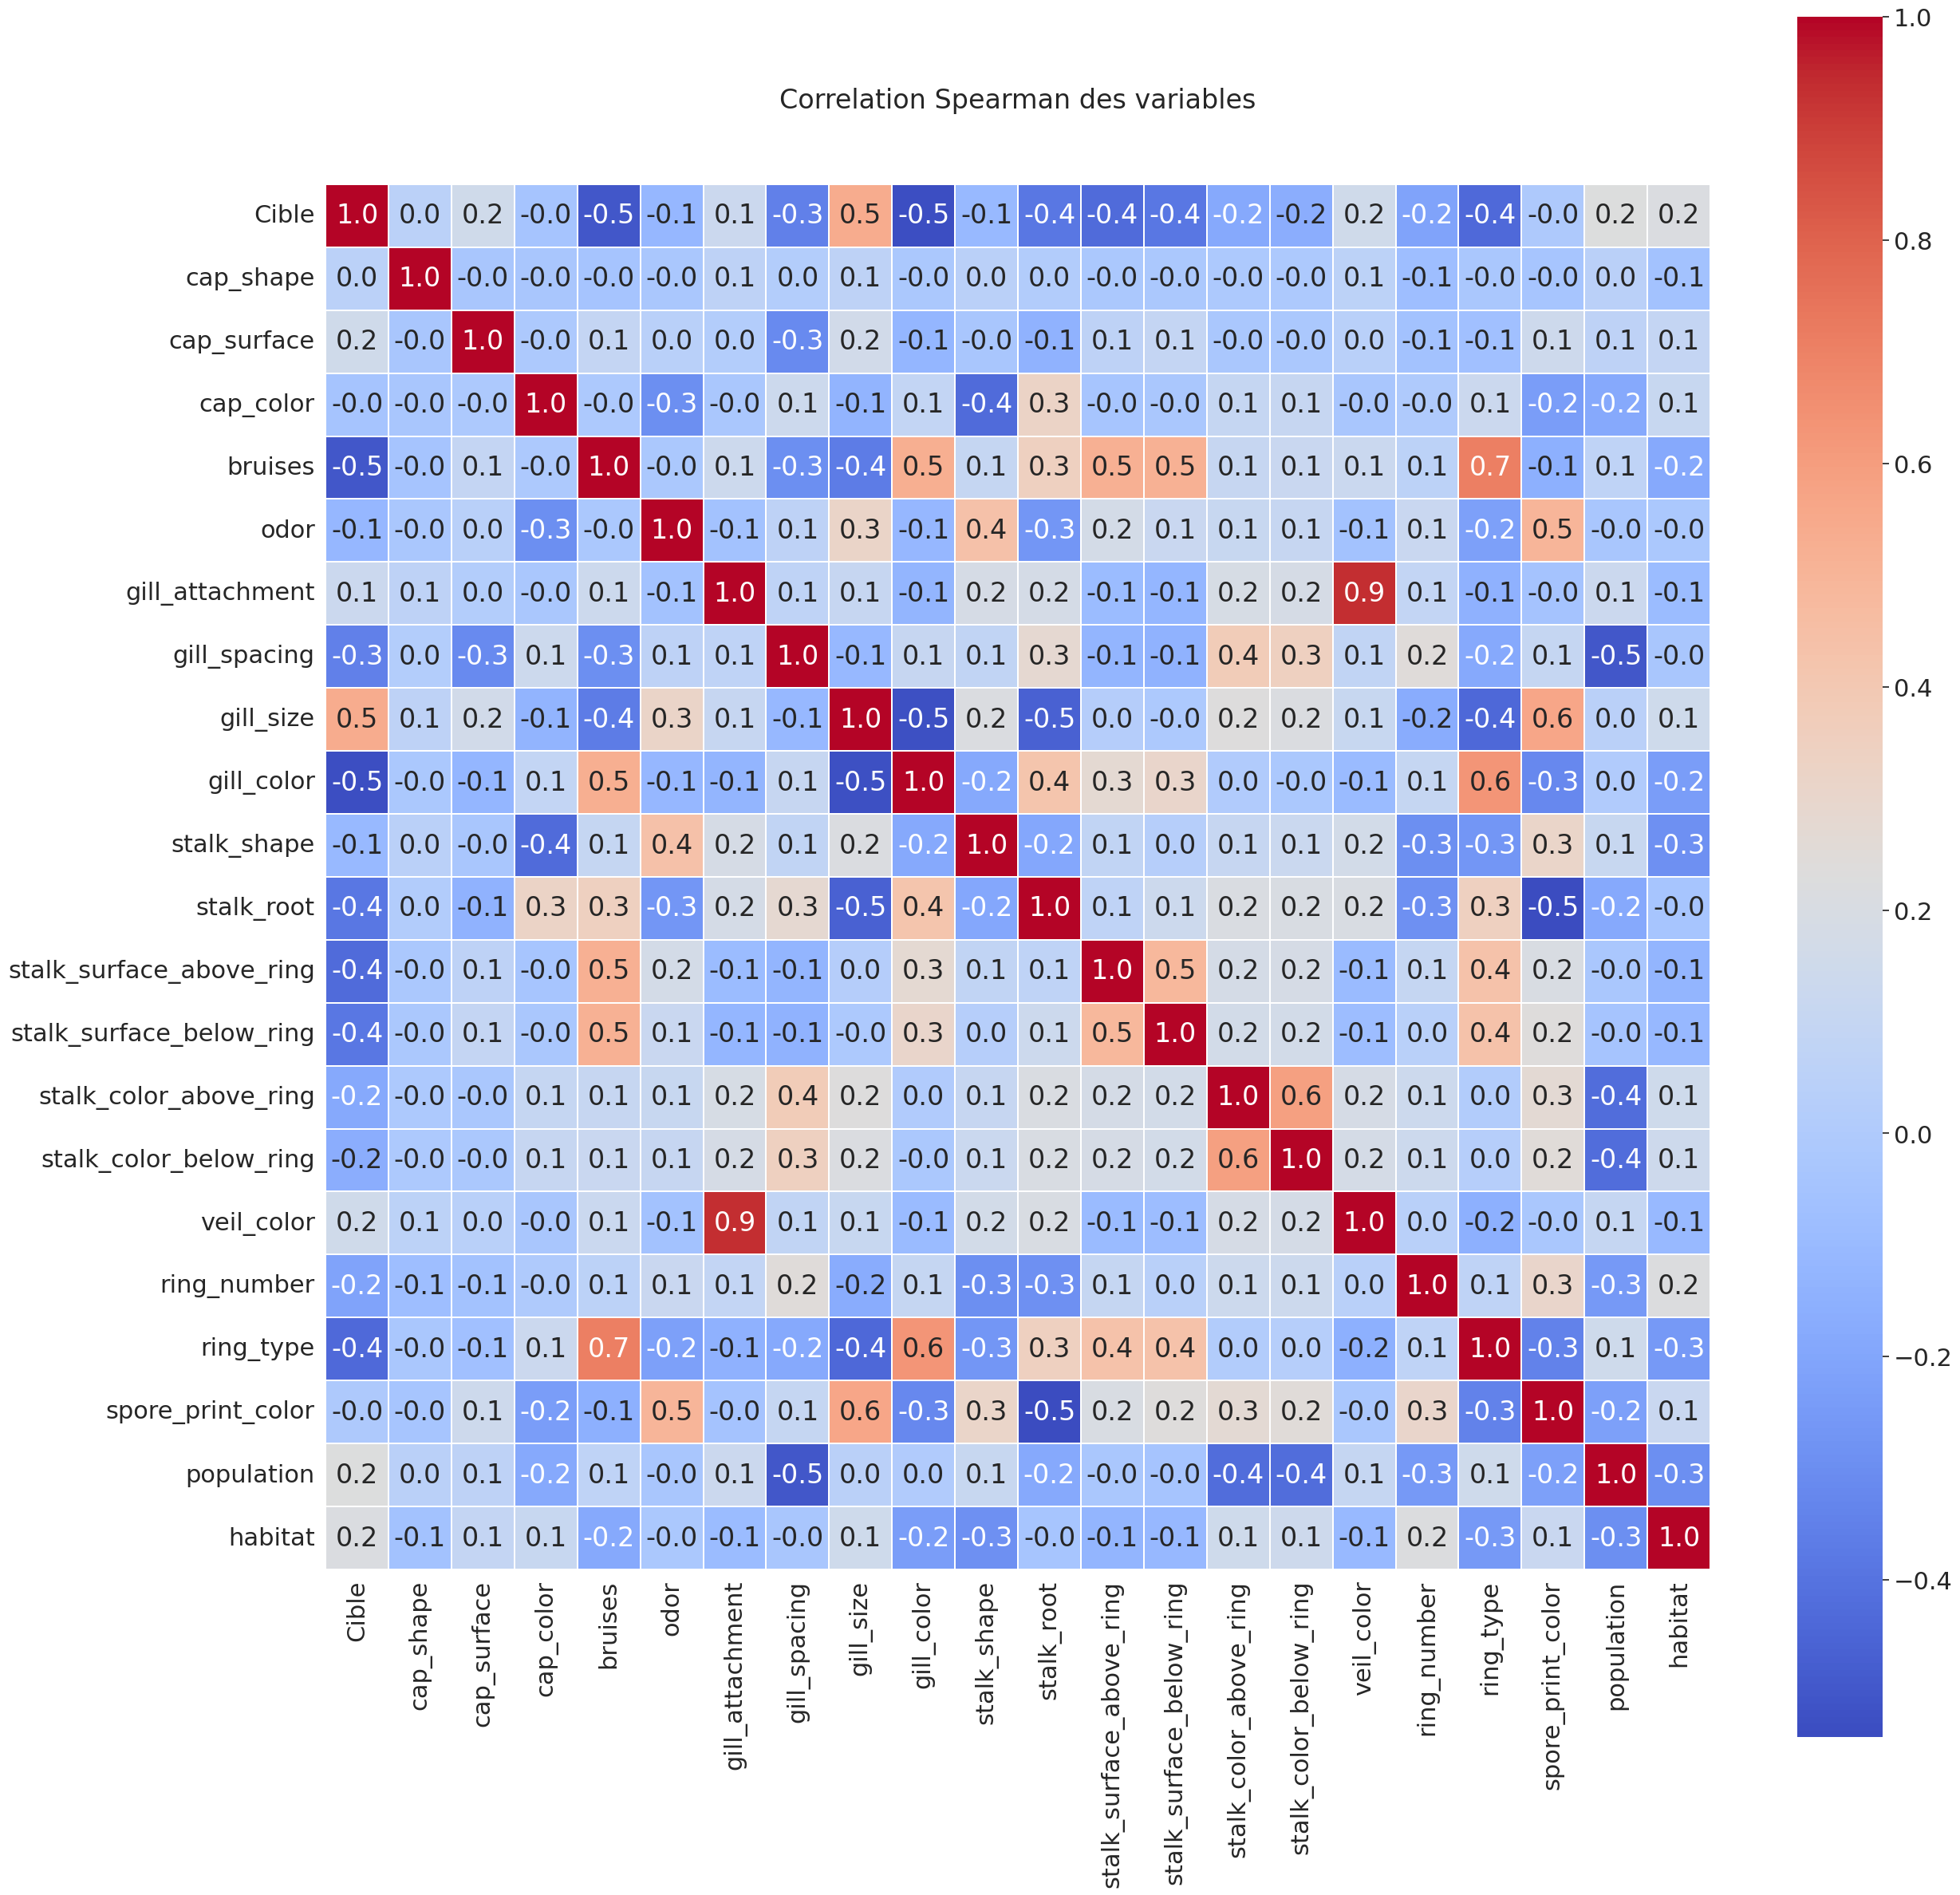

In [16]:
plt.figure(figsize=(28,28))
sns.set(font_scale=2)
plt.title('Correlation Spearman des variables', y=1.05, size=24)
sns.heatmap(donnees.corr(method='spearman'), fmt= '.1f',linewidths=0.3,vmax=1.0, 
            square=True, cmap='coolwarm', linecolor='white', annot=True);

In [17]:
donnees.columns

Index(['Cible', 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor',
       'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color',
       'stalk_shape', 'stalk_root', 'stalk_surface_above_ring',
       'stalk_surface_below_ring', 'stalk_color_above_ring',
       'stalk_color_below_ring', 'veil_color', 'ring_number', 'ring_type',
       'spore_print_color', 'population', 'habitat'],
      dtype='object')

In [18]:
donnees.shape

(8124, 22)

In [19]:
donnees.reset_index().head()

,index,Cible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,...,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,0,1,5,2,4,1,6,1,0,1,...,2,2,7,7,2,1,4,2,3,5
1,1,0,5,2,9,1,0,1,0,0,...,2,2,7,7,2,1,4,3,2,1
2,2,0,0,2,8,1,3,1,0,0,...,2,2,7,7,2,1,4,3,2,3
3,3,1,5,3,8,1,6,1,0,1,...,2,2,7,7,2,1,4,2,3,5
4,4,0,5,2,3,0,5,1,1,0,...,2,2,7,7,2,1,0,3,0,1


In [20]:
donnees.cap_shape.unique()

array([5, 0, 4, 2, 3, 1])

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    donnees.iloc[:,1:], 
    donnees.Cible, 
    test_size=0.12, 
    random_state=0, 
    stratify = donnees.Cible) 

In [22]:
indexTrain = X_train.reset_index().iloc[:,0].values
indexTest  = X_test.reset_index().iloc[:,0].values


import pickle
pickle_file = "champignons.Index.pickle"

with open(pickle_file, 'wb') as f:
    pickle.dump( indexTrain  ,f)
    pickle.dump( indexTest   ,f)  

In [23]:
import pickle
pickle_file = "champignons.Index.pickle"

with open(pickle_file, 'rb') as f:
    indexTrain = pickle.load(f)
    indexTest  = pickle.load(f)

In [24]:
donneesSav = cp.deepcopy(donnees)

In [25]:
X_train, X_test, y_train, y_test = donnees.filter(items=indexTrain,axis=0).drop(columns=['Cible'],axis=1),\
                                   donnees.filter(items=indexTest ,axis=0).drop(columns=['Cible'],axis=1),\
                                   donnees.filter(items=indexTrain,axis=0).Cible,\
                                   donnees.filter(items=indexTest ,axis=0).Cible

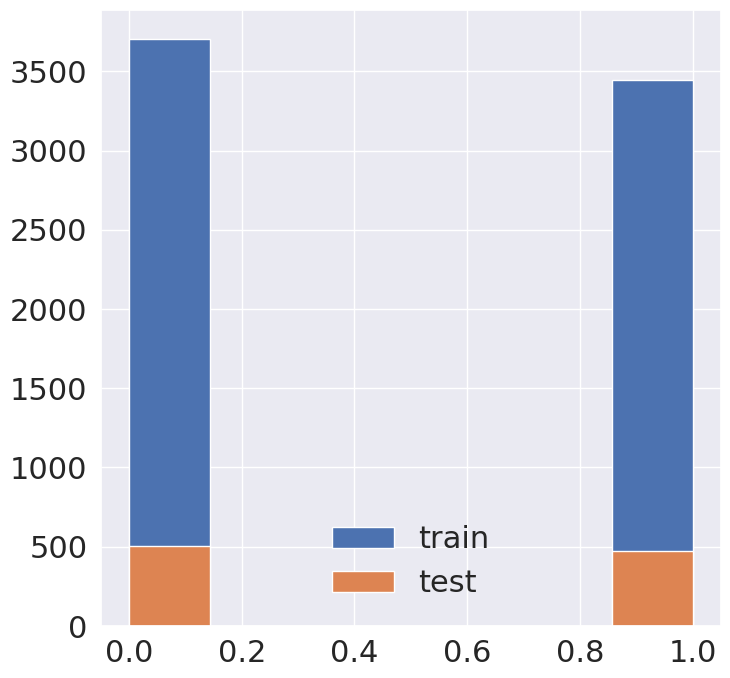

In [26]:
y_train.hist(bins=7, figsize=(8,8), label='train');
y_test.hist(bins=7, figsize=(8,8), label='test');
plt.legend();

# Le déclaration des classifieurs 

In [27]:

names = [
            'Decision Tree', 
            'Random_Forest',
            'AdaBoost',
            # 'LightGBM',
            'XGBoost',
            'LogisticRegression',
            'Gaussian_Process',
            'Nearest_Neighbors',
            'Linaire_SVMC',
            'Radial_SVMC',
            'Poly_SVMC', 
            'GaussianNaiveBayes',
            'QuadraticDiscriminant',
            'Neural_Net'
        ]

classifiers = [
            DecisionTreeClassifier(max_depth=5),
            RandomForestClassifier(
                max_depth=6,
                max_features=3,
                min_samples_split=4,
                n_estimators=52,
                n_jobs=-1
            ),
            AdaBoostClassifier(n_estimators=52),    
            # LGBMClassifier(
            #     learning_rate=0.1,
            #     n_estimators=56,
            #     num_leaves=20,
            #     reg_alpha=0.1,
            #     reg_lambda=20,
            # ),
            XGBClassifier(
                objective='binary:logistic',
                eval_metric='auc',
                n_estimators=52,
                max_depth=6,
                use_label_encoder=False
            ),
            LogisticRegression(
                C=0.81113,
                max_iter=8000,
                penalty='l2',
                solver='lbfgs',
                n_jobs=-1
            ),
            GaussianProcessClassifier(
                n_jobs=-1
            ),
            KNeighborsClassifier(
                algorithm='ball_tree',
                n_neighbors=17,
                p=1,
                weights='distance',
                n_jobs=-1
            ),
            NuSVC(
                kernel="linear",
                nu=0.25,
                probability=True,
            ),
            NuSVC(
                kernel="rbf",
                gamma=0.5,
                nu=0.1,
                probability=True,
            ),
            NuSVC(
                kernel="poly",
                degree=3,
                nu=0.1,
                probability=True,
            ),
            GaussianNB(),
            QuadraticDiscriminantAnalysis(),
            MLPClassifier(alpha=1),
        ]

dictModels = {name:clf for name, clf in zip(names, classifiers)}

In [28]:
dictModels

{'Decision Tree': DecisionTreeClassifier(max_depth=5),
 'Random_Forest': RandomForestClassifier(max_depth=6, max_features=3, min_samples_split=4,
                        n_estimators=52, n_jobs=-1),
 'AdaBoost': AdaBoostClassifier(n_estimators=52),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='auc', feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=52, n_jobs=None, num_parallel_tree=None,
               predictor=None, rand

# Le choix des classifieurs 

In [29]:
def choixClassifieurs(X_train, y_train,X_test, y_test, dictModels):
    np.random.seed(123456)
    t0 = time.time()  
    # h = .02  # step size in the mesh
    lw = 1

    plt.figure(figsize=(18,36))
    if int(str(sns.__version__).split('.')[1]) > 8 : 
        plt.style.use('seaborn-v0_8-darkgrid')
    else:
        plt.style.use('seaborn-darkgrid')
    couleurs = sns.hls_palette(len(dictModels.keys()), l=.4, s=.9)
    r_acc,r_aucROC = dict(),dict()
    fauxPositifs, vraisPositifs, probabilites = dict(),dict(),dict()
    accuracy,logloss,hammingloss,precision,sensibilite,f1,jaccard = dict(),dict(),dict(),dict(),dict(),dict(),dict()
    prec, rec, tauxPR, avgPrecRec =  dict(),dict(),dict(),dict()

    for i, nom in enumerate(dictModels):    
        t1 = time.time()  
        dictModels[nom].fit(X_train, y_train)

        y_probas = dictModels[nom].predict_proba(X_test)
        y_pred = dictModels[nom].predict(X_test)
        fauxPositifs[nom], vraisPositifs[nom], probabilites[nom] = roc_curve(y_test.ravel(), y_probas[:, 1])

        r_aucROC[nom]     = auc(fauxPositifs[nom], vraisPositifs[nom])
        accuracy[nom]     = accuracy_score(y_test,y_pred)
        logloss[nom]      = log_loss(y_test,y_pred)
        hammingloss[nom]  = hamming_loss(y_test,y_pred)
        precision[nom]    = precision_score(y_test,y_pred)
        sensibilite[nom]  = recall_score(y_test,y_pred)
        f1[nom]           = f1_score(y_test,y_pred)
        jaccard[nom]      = jaccard_score(y_test,y_pred)


        prec[nom], rec[nom], tauxPR[nom] = precision_recall_curve(y_test.ravel(), y_probas[:, 1])
        avgPrecRec[nom] = average_precision_score(y_test.ravel(), y_probas[:, 1])

        print(f'{nom:21s}'+(' %.4f' % accuracy[nom]).lstrip('0'),end='\t--\t')
        print ("Area under the ROC curve : %0.4f" % r_aucROC[nom],end='\t--\t')
        print('Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0'))

        plt.subplot(2, 1, 1)
        plt.plot(fauxPositifs[nom], vraisPositifs[nom], color=couleurs[i], label=nom + '(AUC = %0.4f)' % r_aucROC[nom])

        plt.subplot(2, 1, 2)
        plt.step(rec[nom], prec[nom], where='post', color=couleurs[i], label=f"{nom}(AP = {avgPrecRec[nom]:0.8f})")#alpha=0.8, 
        plt.fill_between(rec[nom], prec[nom], step='post', alpha=0.05)



    plt.subplot(2, 1, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Le taux de faux Positifs-(1 - Spécificité) = VN / (FP + VN)',size=18)
    plt.ylabel('Le taux de vrais positifs-Sensibilité = VP / (VP + FN)',size=18)
    plt.title('La courbe ROC (Receiver Operating Caracteristic)',size=20)
    plt.legend(loc="lower right")    

    plt.subplot(2, 1, 2)
    f_scores = np.linspace(0.2, 0.9, num=7)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    # plt.subplot(2, 1, 2)                
    # plt.plot([0, 1], [0.5, 0.5], 'k--')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Sensibilité(Rappel) = VP / (VP + FN)', size=18)
    plt.ylabel('Précision = VP / (VP + FP)', size=18)      
    plt.title('La courbe Précision-Rappel',size=20)
    plt.legend(loc="lower left")    

    sauvegarderImage("Les courbes ROC et Précision-Rappel")    
    plt.show()

    print('Exécution  :'+('%.2fs' % (time.time() - t0)).lstrip('0'))

    resultat = pd.DataFrame(pd.Series(r_aucROC), columns=["aucROC"])
    resultat['avgPrecRec']     = pd.Series(avgPrecRec   )
    resultat['accuracy']     = pd.Series(accuracy   )
    resultat['f1']           = pd.Series(f1         )
    resultat['precision']    = pd.Series(precision  )
    resultat['sensibilite']  = pd.Series(sensibilite)
    resultat['logloss']      = pd.Series(logloss    )
    resultat['hammingloss']  = pd.Series(hammingloss)
    resultat['jaccard']      = pd.Series(jaccard    )

    resultat.sort_values('f1',ascending=False, inplace=True)
    return resultat

Decision Tree         0.9795	--	Area under the ROC curve : 0.9965	--	Exécution  :.01s
Random_Forest         0.9938	--	Area under the ROC curve : 1.0000	--	Exécution  :.06s
AdaBoost              1.0000	--	Area under the ROC curve : 1.0000	--	Exécution  :.12s
XGBoost               1.0000	--	Area under the ROC curve : 1.0000	--	Exécution  :.07s
LogisticRegression    0.9538	--	Area under the ROC curve : 0.9820	--	Exécution  :.47s
Gaussian_Process      1.0000	--	Area under the ROC curve : 1.0000	--	Exécution  :18.71s
Nearest_Neighbors     1.0000	--	Area under the ROC curve : 1.0000	--	Exécution  :.12s
Linaire_SVMC          0.9477	--	Area under the ROC curve : 0.9588	--	Exécution  :1.63s
Radial_SVMC           1.0000	--	Area under the ROC curve : 1.0000	--	Exécution  :5.56s
Poly_SVMC             0.9969	--	Area under the ROC curve : 0.9999	--	Exécution  :.84s
GaussianNaiveBayes    0.9221	--	Area under the ROC curve : 0.9509	--	Exécution  :.01s
QuadraticDiscriminant 0.9969	--	Area under the ROC

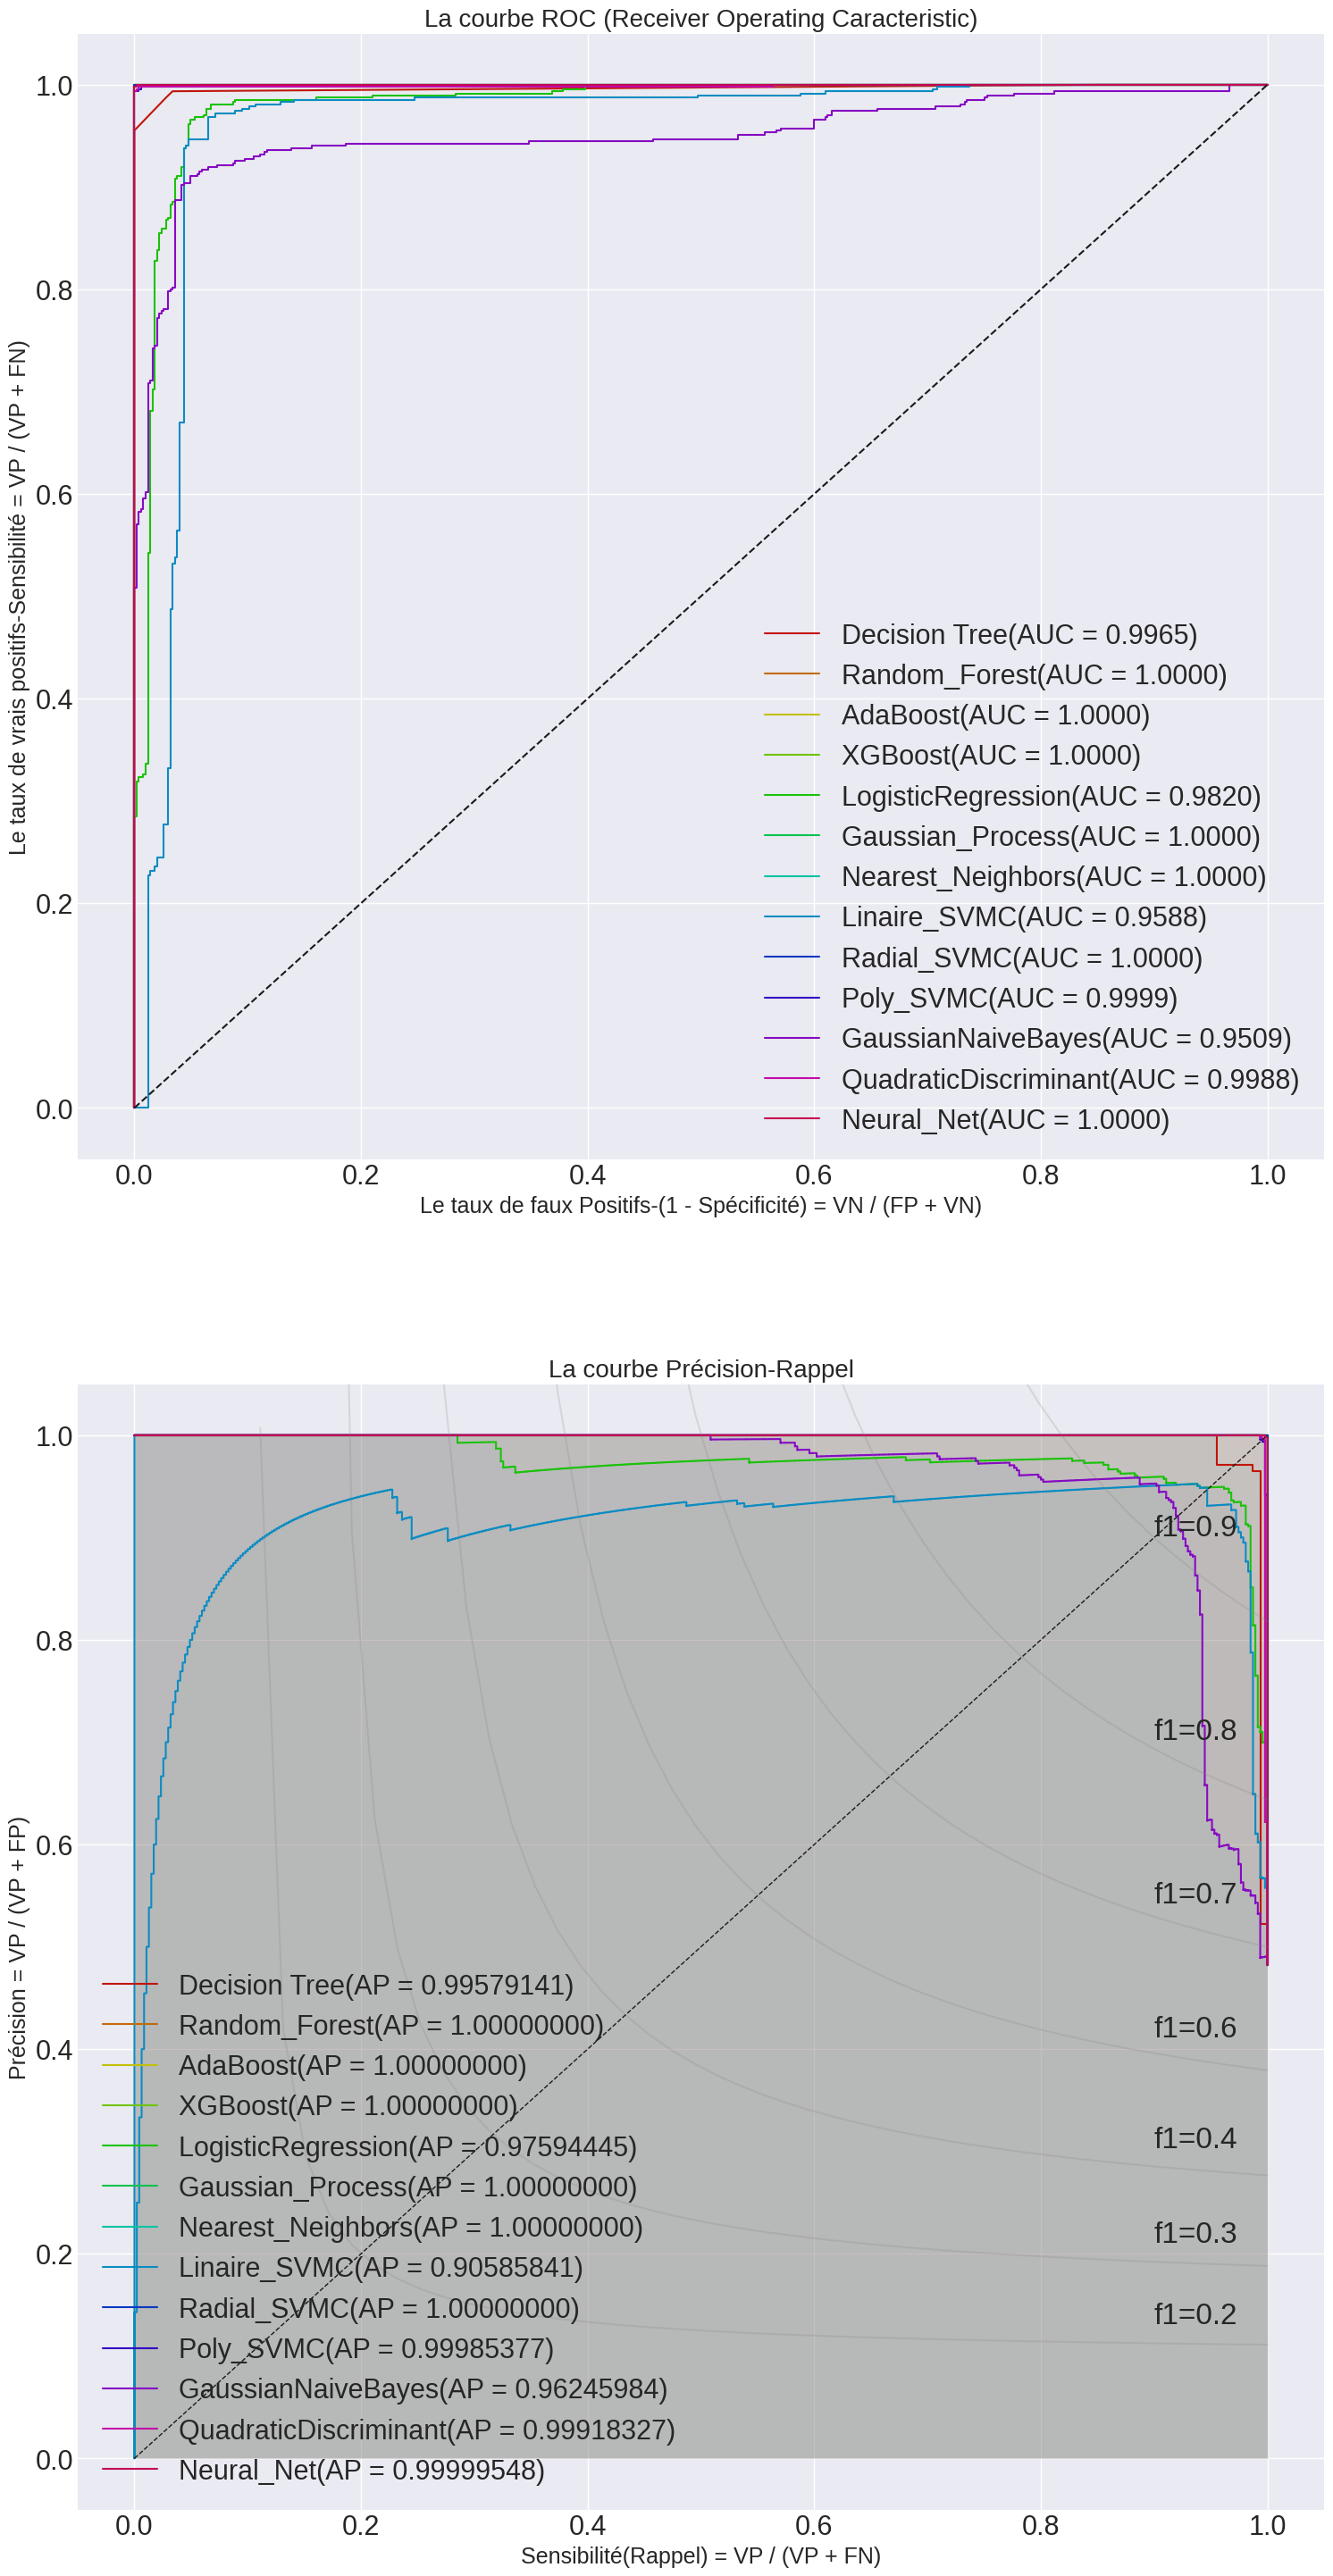

Exécution  :36.22s


In [30]:
resultatsBase = choixClassifieurs(X_train, y_train,X_test, y_test, dictModels)

In [31]:
resultatsBase

,aucROC,avgPrecRec,accuracy,f1,precision,sensibilite,logloss,hammingloss,jaccard
AdaBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.220446e-16,0.000000,1.000000
XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.220446e-16,0.000000,1.000000
Gaussian_Process,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.220446e-16,0.000000,1.000000
Nearest_Neighbors,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.220446e-16,0.000000,1.000000
Radial_SVMC,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.220446e-16,0.000000,1.000000
Poly_SVMC,0.999857,0.999854,0.996923,0.996798,1.000000,0.993617,1.109035e-01,0.003077,0.993617
QuadraticDiscriminant,0.998787,0.999183,0.996923,0.996798,1.000000,0.993617,1.109035e-01,0.003077,0.993617
Neural_Net,0.999996,0.999995,0.996923,0.996798,1.000000,0.993617,1.109035e-01,0.003077,0.993617
Random_Forest,1.000000,1.000000,0.993846,0.993576,1.000000,0.987234,2.218071e-01,0.006154,0.987234
Decision Tree,0.996537,0.995791,0.979487,0.978903,0.970711,0.987234,7.393570e-01,0.020513,0.958678
